In [1]:
import sys
sys.path.append('../')
import tensorflow as tf
import numpy as np
from os import environ as env
from os import path
from dataset_utils.md_utils import md_dataset
from dataset_utils.mai_utils import mai_dataset
from dataset_utils.viz_utils import visualize_multiple_imag_rows
from dataset_utils.aug_utils import color_jitter, salty_noise, random_rotation, random_crop_and_resize, cascade_functions
from  matplotlib import pyplot as plt

2021-10-06 10:51:16.785968: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
gen_data_dir = os.environ['DATA_DIR']
dataset_type = 'mai'
dataset_locations = {"md": "MegaDepth_v1",
                     "mai": "MAI2021_dataset"}

dataset_name = dataset_locations[dataset_type]
data_dir = path.join(gen_data_dir, dataset_name)


In [3]:
# Define Augmentation Functions
jitter = color_jitter(0.9, brightness=0.1, contrast=0.1, saturation=0.1, hue = 0.1)
salt_noise = salty_noise(0.9, 0.01)
normalization_img = lambda x: x
normalization_depth = lambda x: x
combined_input_aug = cascade_functions([jitter, salt_noise, normalization_img])
combined_input_aug = None

crop_resize_transform = random_crop_and_resize(prob=0.9, min_size=0.6, max_size=1.0, img_shape= (224,224), center_crop=False)
rotation_aug_transform = random_rotation(0.9, 2.5)

# Cascaded geometric transformation
geometric_augmentation = cascade_functions([crop_resize_transform, rotation_aug_transform])
geometric_augmentation = None

# Note negative probability, for stability. Don't want to crop in validation
val_geometric_transform = random_crop_and_resize(prob=-1e-5, img_shape=(128,128))
val_geometric_transform = None

shuffle = True

batch_size = 8

random_seed = 1
in_transform = lambda x: tf.image.resize(x, size = (224,224), method = tf.image.ResizeMethod.BILINEAR)
if dataset_type == 'md':
    # Data generator
    depth_type = 'npy'
    tf.random.set_seed(random_seed)
    data_gen = md_dataset(data_dir, mode='train', input_shape=(224,224), depth_type=depth_type,
                            batch_size=batch_size,
                            random_flip=False,
                            n_images=None,
                            in_transform=in_transform,
                            out_transform=None,
                            io_transform =val_geometric_transform,
                            shuffle=shuffle)

    print(f"Loaded train partition, length {data_gen.__len__()} and batch size: {batch_size}")
    tf.random.set_seed(random_seed)
    data_gen_aug = md_dataset(data_dir, mode='train', input_shape=(224,224), depth_type=depth_type,
                            batch_size=batch_size,
                            random_flip=True,
                            n_images=None,
                            in_transform=combined_input_aug,
                            out_transform=normalization_depth,
                            io_transform =geometric_augmentation,
                            shuffle=shuffle)

    print(f"Loaded train partition augmented, length {data_gen.__len__()} and batch size: {batch_size}")
    tf.random.set_seed(random_seed)
    data_gen_val =  md_dataset(data_dir, mode='train', input_shape=(224,224), depth_type=depth_type,
                            batch_size=32,
                            random_flip=False,
                            n_images=None,
                            in_transform=normalization_img,
                            out_transform=normalization_depth,
                            io_transform =val_geometric_transform,
                            shuffle=shuffle)
    print(f"Loaded validation partition with length {data_gen_val.__len__()} and batch size: {batch_size}")

elif dataset_type == 'mai':

    tf.random.set_seed(random_seed)
    data_gen = mai_dataset(data_dir, mode='train', input_shape=(480//2, 640//2),
                            batch_size=batch_size,
                            random_flip=False,
                            in_transform=in_transform,
                            out_transform=None,
                            io_transform=val_geometric_transform,
                            shuffle=shuffle)
    print(f"Loaded train partition, length {data_gen.__len__()} and batch size: {batch_size}")

    tf.random.set_seed(random_seed)
    data_gen_aug = mai_dataset(data_dir, mode='train', input_shape=(480//2, 640//2),
                            batch_size=batch_size,
                            random_flip=True,
                            in_transform=combined_input_aug,
                            out_transform=normalization_depth,
                            io_transform=geometric_augmentation,
                            shuffle=shuffle)
    print(f"Loaded train partition augmented, length {data_gen.__len__()} and batch size: {batch_size}")

    tf.random.set_seed(random_seed)
    data_gen_val = mai_dataset(data_dir, mode='train', input_shape=(480//2, 640//2),
                            batch_size=batch_size,
                            random_flip=False,
                            in_transform=combined_input_aug,
                            out_transform=normalization_depth,
                            io_transform=geometric_augmentation,
                            shuffle=shuffle)
    print(f"Loaded validation partition with length {data_gen_val.__len__()} and batch size: {batch_size}")

Dataset with 6646 elements.


2021-10-06 10:51:23.365333: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-06 10:51:23.368356: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-06 10:51:23.523747: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-10-06 10:51:23.523801: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (minga): /proc/driver/nvidia/version does not exist
2021-10-06 10:51:23.524466: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-06 10:

Loaded train partition, length 831 and batch size: 8
Dataset with 6646 elements.
Loaded train partition augmented, length 831 and batch size: 8
Dataset with 6646 elements.
Loaded validation partition with length 831 and batch size: 8


2021-10-06 10:51:24.132049: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-06 10:51:24.149804: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3492290000 Hz


Original input/target types: in=[0,255] (<dtype: 'uint8'>) [(8, 224, 224, 3)]  out=[0.0,39990.0] (float32) [(8, 240, 320, 1)] 
Augmented input/target types: in=[0,255] (<dtype: 'uint8'>)[(8, 240, 320, 3)]  out=[0.0,39990.0] (float32) [(8, 240, 320, 1)]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Img min, max, mean, median: [6, 255, 83.19458173894557, 74.0]
Histogram: [ 9021 31954 44446 27653 17414  9642  5771  2345   731  1551] 
Edges: [  6.   30.9  55.8  80.7 105.6 130.5 155.4 180.3 205.2 230.1 255. ]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Img min, max, mean, median: [6, 255, 83.2903125, 74.0]
Histogram: [14660 49435 67367 41028 26477 14773  8992  3720  1168  2780] 
Edges

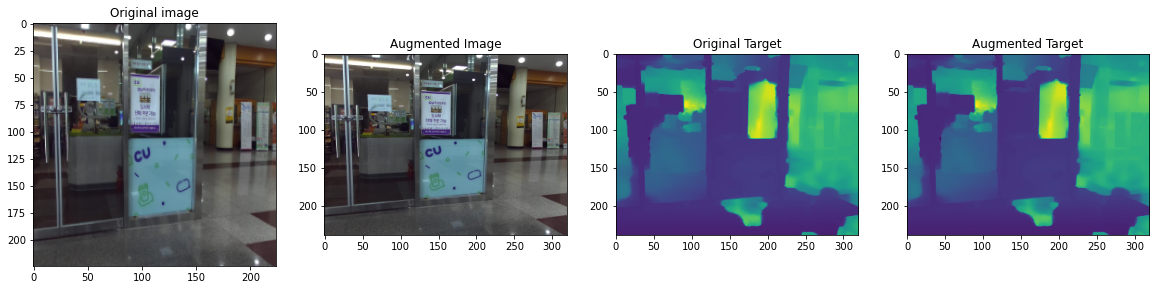

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Img min, max, mean, median: [3, 255, 99.50814466411565, 115.0]
Histogram: [11527 18415 15363 14843 48578 38292  1998   828   290   394] 
Edges: [  3.   28.2  53.4  78.6 103.8 129.  154.2 179.4 204.6 229.8 255. ]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Img min, max, mean, median: [3, 255, 99.6230295138889, 115.0]
Histogram: [18016 28403 23186 22703 73011 59274  3402  1277   463   665] 
Edges: [  3.   28.2  53.4  78.6 103.8 129.  154.2 179.4 204.6 229.8 255. ]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

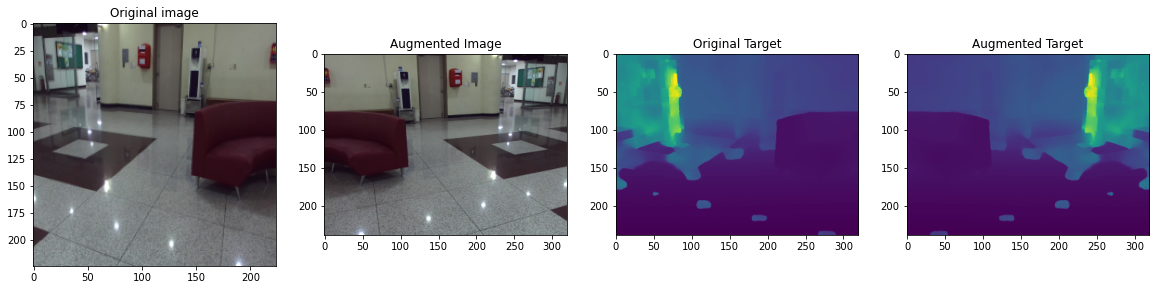

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Img min, max, mean, median: [2, 202, 96.28781356292517, 91.0]
Histogram: [13752 11969 24572 17380 12917 12344 17080 17138 20944  2432] 
Edges: [  2.  22.  42.  62.  82. 102. 122. 142. 162. 182. 202.]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Img min, max, mean, median: [2, 205, 96.4121267361111, 91.0]
Histogram: [23648 17206 37767 27280 18578 19637 26969 27767 29125  2423] 
Edges: [  2.   22.3  42.6  62.9  83.2 103.5 123.8 144.1 164.4 184.7 205. ]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

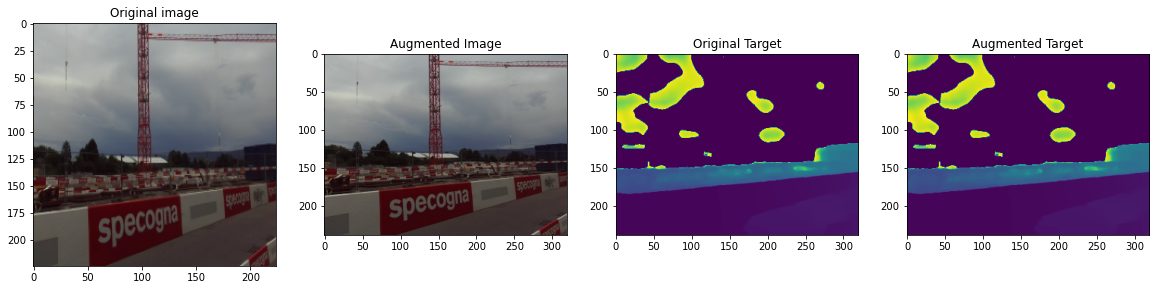

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Img min, max, mean, median: [5, 255, 97.96849091198979, 47.0]
Histogram: [37392 50192 13387  4021  2520   514   343   898  7161 34100] 
Edges: [  5.  30.  55.  80. 105. 130. 155. 180. 205. 230. 255.]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Img min, max, mean, median: [5, 255, 98.09865451388889, 47.0]
Histogram: [57265 76541 20654  5823  4291   745   475  1283 10961 52362] 
Edges: [  5.  30.  55.  80. 105. 130. 155. 180. 205. 230. 255.]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

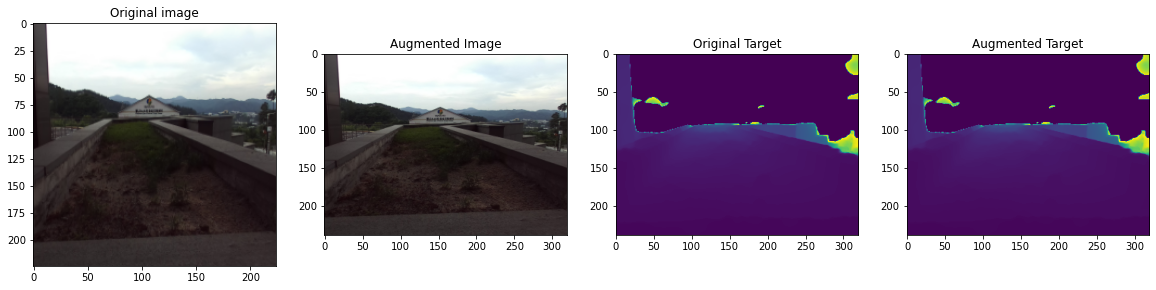

In [4]:
seed = 2
tf.random.set_seed(seed)
data_gen_it = data_gen.as_numpy_iterator()
tf.random.set_seed(seed)
data_gen_aug_it = data_gen_aug.as_numpy_iterator()
orig_input_batch, orig_target_batch = data_gen_it.next()
aug_input_batch, aug_target_batch = data_gen_aug_it.next()
orig_input_batch = tf.cast(orig_input_batch, tf.uint8)
aug_input_batch = tf.cast(aug_input_batch, tf.uint8)
print("Original input/target types: in=[{},{}] ({}) [{}]  out=[{},{}] ({}) [{}] ".format(
    tf.reduce_min(orig_input_batch),
    tf.reduce_max(orig_input_batch),
    orig_input_batch.dtype,
    orig_input_batch.shape,
    tf.reduce_min(orig_target_batch),
    tf.reduce_max(orig_target_batch),
    orig_target_batch.dtype,
    orig_target_batch.shape
))
print("Augmented input/target types: in=[{},{}] ({})[{}]  out=[{},{}] ({}) [{}]".format(
    tf.reduce_min(aug_input_batch),
    tf.reduce_max(aug_input_batch),
    aug_input_batch.dtype,
    aug_input_batch.shape,
    tf.reduce_min(aug_target_batch),
    tf.reduce_max(aug_target_batch),
    aug_target_batch.dtype,
    aug_target_batch.shape
))

img_batches = [orig_input_batch, aug_input_batch, orig_target_batch, aug_target_batch]
labels = ['Original image', 'Augmented Image', 'Original Target', 'Augmented Target']
visualize_multiple_imag_rows(img_batches, labels, n_samples = 4, histogram=True, color_map='viridis')
   


In [6]:

out_dir = '/srv/beegfs02/scratch/efficient_nn_mobile/data/test_outputs'
samples_to_store = [1]
for indx in samples_to_store:
    img = tf.squeeze(img_batches[1][indx])
    img = img.numpy()
    tar = tf.squeeze(img_batches[3][indx])
    tar = tar.numpy()
    file_name = out_dir + '/img{}.png'.format(indx)
    plt.imsave(file_name, np.array(img, dtype=np.uint8))
    file_name = out_dir + '/depth{}.png'.format(indx)
    plt.imsave(file_name, tar)